In [54]:
import numpy
import pandas
from keras import callbacks
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


import theano
theano.config.openmp = True

%matplotlib inline
%env OMP_NUM_THREADS=12

env: OMP_NUM_THREADS=12


In [55]:

def create_dataset_lags(dataset, signal, nblags=1):
    df = dataset.copy();
    for i in range(nblags):
        name = signal + "_" + str(i+1);
        df[name] = dataset[signal].shift(i+1);
    return df

In [56]:
def load_dataset(source , signal):
    dataframe = pandas.read_csv(source, engine='python')
    return dataframe;

def get_lag_names(signal, nblags):
    names = [];
    for i in range(nblags):
        name = signal + "_" + str(i+1);
        names.append(name);
    return names;

def cut_dataset(dataframe , signal, lags):
    train_size = int(dataframe.shape[0] * 0.67)
    lagged_df = create_dataset_lags(dataframe, signal, lags)
    (train_df, test_df) = (lagged_df[0:train_size] , lagged_df[train_size:])
    return (train_df , test_df)

In [129]:
# create and fit the LSTM network

def train_model(train_df , signal, lags, epochs):
    model = Sequential()
    model.add(LSTM(4, input_dim=lags))
    
    model.add(Dense(1))
    model.compile(loss='mape', optimizer='sgd')
    
    lag_names = get_lag_names(signal , lags);
    N = train_df.shape[0] - lags
    NValid = (N * 4) // 5;
    trainX = train_df[lag_names][lags:].values
    trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    trainY = train_df[signal][lags:].values
    estimX = trainX[0:N-NValid]
    estimY = trainY[0:N-NValid]
    valX = trainX[ NValid : ]
    valY = trainY[ NValid : ]

    lStopCallback = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')
    lHistory = model.fit(estimX, estimY, nb_epoch=epochs, batch_size=1, validation_data=(valX , valY), verbose=2, 
                        callbacks=[lStopCallback])
    print(lHistory.__dict__)
    return model;

def plot_model(model):
    from IPython.display import SVG
    from keras.utils.visualize_util import model_to_dot

    SVG(model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

    

In [130]:
# make predictions

def compute_L2_MAPE(signal , estimator):
    lMean = numpy.mean( (signal - estimator)**2 );
    lMAPE = numpy.mean( numpy.abs((signal - estimator) / signal ));
    lL2 = numpy.sqrt(lMean);
    return (lL2 , lMAPE);


def predict_signal(model, signal, nblags, train_df, test_df, idataframe):
    lag_names = get_lag_names(signal , nblags);
    trainX = train_df[lag_names].values
    trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    trainPredict = model.predict(trainX)
    testX = test_df[lag_names].values
    testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    testPredict = model.predict(testX)
    
    # calculate root mean squared error
    lTrainL2 = compute_L2_MAPE(train_df[signal][nblags:].values, trainPredict[nblags:])
    lTestL2 = compute_L2_MAPE(test_df[signal].values, testPredict)
    print('TRAIN_TEST_RMSE_MAPE', lTrainL2 , lTestL2)

    out_df = pandas.DataFrame()
    out_df = idataframe.copy();
    out_N = out_df.shape[0]
    out_df['Time'] = range(out_N)
    # out_df['scaled_output'] = 0;
    lSeries = pandas.Series();
    lSeries[:] = numpy.nan
    lSeries1 = pandas.Series(trainPredict.ravel());
    lSeries2 = pandas.Series(testPredict.ravel());
    # print(out_N , lSeries.shape[0], lSeries1.shape[0], lSeries2.shape[0])
    lSeries = lSeries.append(lSeries1);
    lSeries = lSeries.append(lSeries2);
    out_df['output'] = lSeries.values;
    out_df['output'] = out_df['output'];
    return out_df;



In [131]:

def full_test(dataset, signal, nblags , epochs):
    full_df = load_dataset(dataset , signal);
    (train_df, test_df) = cut_dataset(full_df, signal , nblags);
    model = train_model(train_df, signal , nblags, epochs);
    plot_model(model);
    out_df = predict_signal(model, signal, nblags, train_df, test_df, full_df);
    lNewName = signal + "_" + str(nblags) +  "_" + str(epochs) 
    out_df[lNewName] = out_df[signal]
    out_df.plot('Time' , [lNewName,  'output'] , figsize=(22,12));

    
    

Train on 29 samples, validate on 29 samples
Epoch 1/300
0s - loss: 56.6048 - val_loss: 43.2108
Epoch 2/300
0s - loss: 24.3184 - val_loss: 69.2062
Epoch 3/300
0s - loss: 27.0288 - val_loss: 48.1701
Epoch 4/300
0s - loss: 27.1756 - val_loss: 55.6747
Epoch 5/300
0s - loss: 24.8741 - val_loss: 57.8574
Epoch 6/300
0s - loss: 26.8900 - val_loss: 56.4575
Epoch 7/300
Epoch 00006: early stopping
0s - loss: 26.1610 - val_loss: 45.3413
{'epoch': [0, 1, 2, 3, 4, 5, 6], 'model': <keras.models.Sequential object at 0x7f6917e18f98>, 'history': {'loss': [56.604821977944212, 24.318433794482001, 27.028795032665649, 27.17556122253681, 24.874093791534161, 26.890008595483057, 26.160982964367701], 'val_loss': [43.210765834255469, 69.206214904785156, 48.170081541456028, 55.674749353836326, 57.857365723313954, 56.457540273666382, 45.341343596063808]}, 'params': {'batch_size': 1, 'do_validation': True, 'verbose': 2, 'nb_epoch': 300, 'metrics': ['loss', 'val_loss'], 'nb_sample': 29}}
TRAIN_TEST_RMSE_MAPE (1.5376

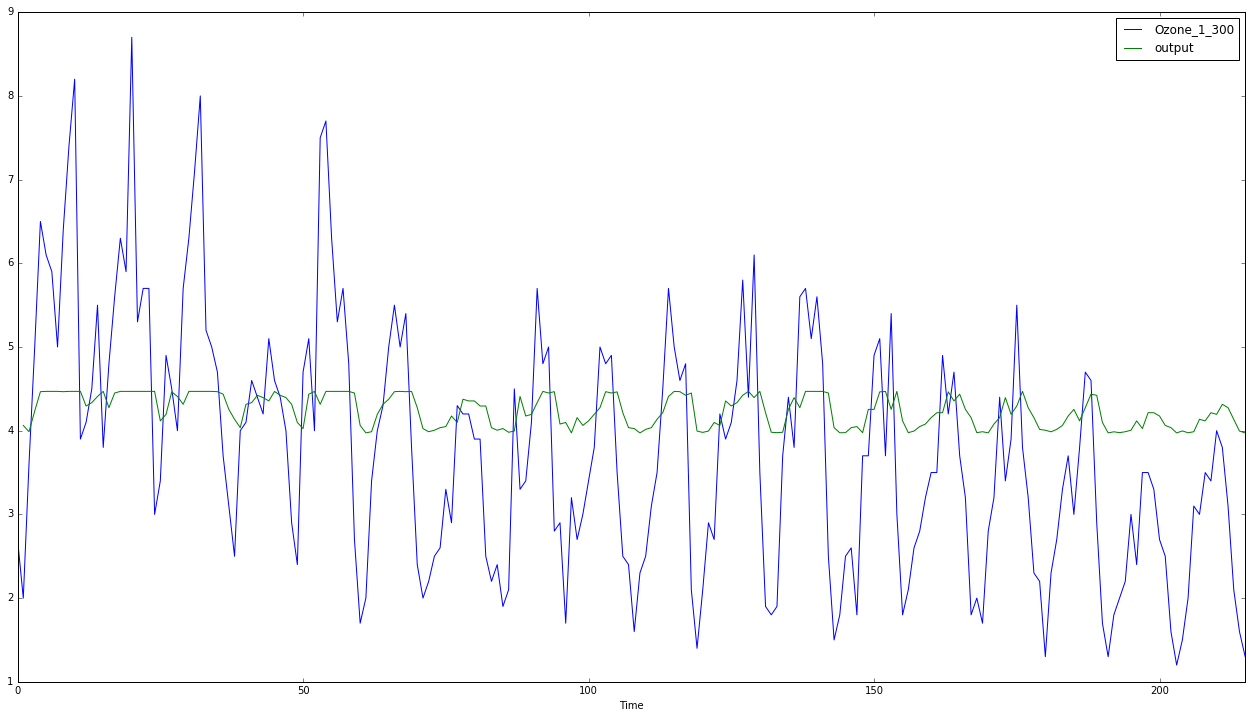

In [132]:
full_test('../data/ozone-la.csv', 'Ozone', 1, 300)

In [88]:
#for ep in [10 , 40, 160, 640]:
#    for lags in [8 ,32]:
#        full_test('../data/passengers_train.csv', 'AirPassengers',lags, ep)


Train on 17 samples, validate on 17 samples
Epoch 1/500
0s - loss: 100.1912 - val_loss: 100.0564
Epoch 2/500
0s - loss: 100.0607 - val_loss: 99.9961
Epoch 3/500
0s - loss: 99.9302 - val_loss: 99.9358
Epoch 4/500
0s - loss: 99.7997 - val_loss: 99.8754
Epoch 5/500
0s - loss: 99.6692 - val_loss: 99.8151
Epoch 6/500
0s - loss: 99.5387 - val_loss: 99.7547
Epoch 7/500
0s - loss: 99.4082 - val_loss: 99.6944
Epoch 8/500
0s - loss: 99.2776 - val_loss: 99.6341
Epoch 9/500
0s - loss: 99.1471 - val_loss: 99.5737
Epoch 10/500
0s - loss: 99.0166 - val_loss: 99.5134
Epoch 11/500
0s - loss: 98.8861 - val_loss: 99.4530
Epoch 12/500
0s - loss: 98.7556 - val_loss: 99.3927
Epoch 13/500
0s - loss: 98.6251 - val_loss: 99.3324
Epoch 14/500
0s - loss: 98.4946 - val_loss: 99.2720
Epoch 15/500
0s - loss: 98.3640 - val_loss: 99.2117
Epoch 16/500
0s - loss: 98.2335 - val_loss: 99.1513
Epoch 17/500
0s - loss: 98.1030 - val_loss: 99.0910
Epoch 18/500
0s - loss: 97.9725 - val_loss: 99.0307
Epoch 19/500
0s - loss: 97

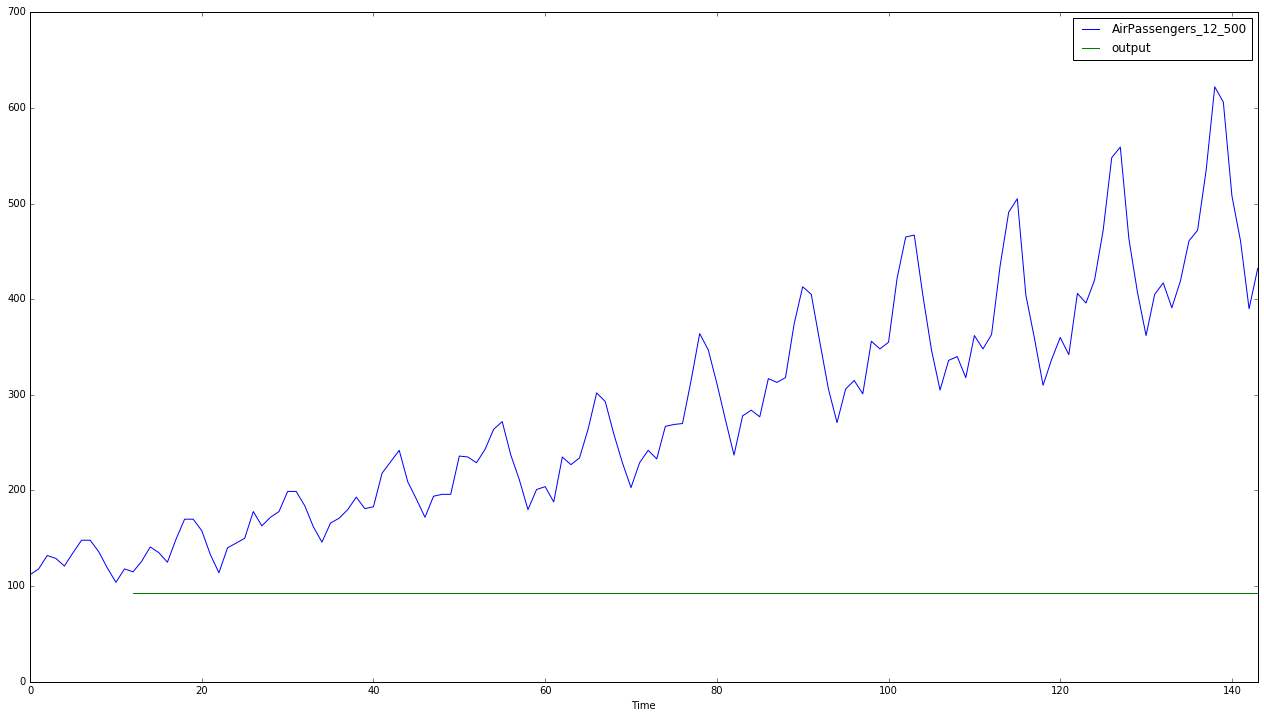

In [133]:
full_test('../data/passengers_train.csv', 'AirPassengers', 12, 500)

In [83]:
callbacks.EarlyStopping?

In [96]:
mod0 = Sequential()


In [97]:
mod0.fit?